# Fine tuning SOTA model (RoBERT) from Hugging Face for Document Classification

In this project, we will try to apply the transfer learning technique for NLP task. We will fine tune [BERT](https://arxiv.org/abs/1810.04805) and [RoBERTa](https://arxiv.org/abs/1907.11692) to do text/document classification. Most of the content are taken from [post1](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) and [post2](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d). In addition, we attempt to make it as general as possible that it can be used for any similar models (thanks to the Transformers library from [hugging face](https://huggingface.co/)) with any dataset by doing just some miner changes. 

In addition, we tried to overcome the limitation of the 512-sequence length of BERT and RoBERTa by using [Longformer](https://arxiv.org/abs/2004.05150) and [RoBERT](https://arxiv.org/abs/1910.10781). It stands for Recurrence over BERT where each ocument is segmented into smaller text and feed each of them to BERT. Then we extract the representation of each text chunk from (pooled_output) and feed the combined representation of each document to LSTM to classify long documents. We will see if this improve the results or overfit the data. We mainly used **python, Transformers, Pytorch, Sklearn**

## Setup


In [1]:
# !pip install -qq -r requirements.txt

!pip install -qq ipywidgets

!pip install -qq --upgrade jupyter_client

!pip install -qq nodejs

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# watermark: "An IPython magic extension for printing date and time stamps, version numbers, and hardware information."
!pip install -q -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,seaborn,nltk,sklearn,tensorflow

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

numpy       : 1.18.5
pandas      : 1.1.3
torch       : 1.7.0
transformers: 3.4.0
seaborn     : 0.11.0
nltk        : 3.5
sklearn     : 0.0
tensorflow  : 2.3.1



In [4]:
import transformers
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from datetime import datetime


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 10, 6


In [5]:
x = torch.rand(5, 3)
print(x)
torch.cuda.is_available()

tensor([[0.2572, 0.3028, 0.9656],
        [0.1846, 0.1719, 0.8939],
        [0.9522, 0.9759, 0.4266],
        [0.0087, 0.2060, 0.1032],
        [0.9082, 0.3025, 0.6420]])


True

## Config

We configured this project so we can evaluate different pretrained models with minor changes. All our hyper-parameters are in this section. If you want to use another dataset, check the preprocessing section.

In [6]:
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

"""BERT Model and Tokenizer"""
PRE_TRAINED_MODEL = 'bert-base-cased'
TOKENIZER = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
PT_MODEL = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)

# """RoBERTa Model and Tokenizer"""
# PRE_TRAINED_MODEL = 'roberta-base'
# TOKENIZER = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL)
# PT_MODEL = transformers.RobertaModel.from_pretrained(PRE_TRAINED_MODEL)

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preprocessing



If you use a deferent dataset and reading it as a panda's dataframe, just change the column header that accommodate the content to 'text' and the target column to 'label. Code is provided below.

In [8]:
df = pd.read_csv('../inputs/news_data_groomed.csv')
df.head()

,Unnamed: 0,title,text,label
0,8308,"Italy Plucks 2,000 Migrants from the Mediterra...",ROME (AP) — Italian rescue ships have pluck...,REAL
1,2765,The most unqualified media personalities on TV...,"Monday, November 14, 2016 7:38 AM EST Media pe...",FAKE
2,20123,Rigging the Election – Video IV: Democrat Oper...,Rigging the Election – Video IV: Democrat Oper...,FAKE
3,2669,Will Hillary Select Her Own Prosecutors?,"By Bill Sardi November 1, 2016 Journalist Carl...",FAKE
4,4408,Debate: Washington's Syria policy,The Debate Washington's Syria policy \nIn this...,FAKE


In [9]:
# # df = df.drop(columns=['Unnamed: 0', 'title'])
# df = df.drop_duplicates(subset = ['text', 'label'])
# print(len(pd.read_csv('../inputs/news.csv')) - len(df))

In [10]:
classes = np.unique(df.label)
classes

array(['FAKE', 'REAL'], dtype=object)

In [11]:
# Label encoding to the target feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head(3)

,Unnamed: 0,title,text,label
0,8308,"Italy Plucks 2,000 Migrants from the Mediterra...",ROME (AP) — Italian rescue ships have pluck...,1
1,2765,The most unqualified media personalities on TV...,"Monday, November 14, 2016 7:38 AM EST Media pe...",0
2,20123,Rigging the Election – Video IV: Democrat Oper...,Rigging the Election – Video IV: Democrat Oper...,0


In [12]:
CLASS_NAMES = np.unique(le.inverse_transform(df.label))
CLASS_NAMES

array(['FAKE', 'REAL'], dtype=object)

In [13]:
df.shape

(25059, 4)

In [14]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((21300, 4), (1879, 4), (1880, 4))

## Spliting the data to chuncks

Refernce: https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

We try extracting just the first 3 chunks. In our experience, using all chunks caused overfitting 


In [15]:
def get_split2(text1):
    l_total = []
    l_partial = []
    if len(text1.split()) // 200 > 0:
        n = len(text1.split()) // 200
        # to use the whole document delete this if statement
        if n > 3:
            n = 3
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_partial = text1.split()[:250]
            l_total.append(" ".join(l_partial))
        else:
            l_partial = text1.split()[w*200:w*200 + 250]
            l_total.append(" ".join(l_partial))
    return l_total

In [16]:
df_train['text_split'] = df_train['text'].apply(get_split2)
len(df_train['text_split'][0])#, df_train['text_split'][0]

/share/apps/rc/software/Anaconda3/2020.07/envs/deepNLP2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1

In [17]:
df_train.head()

,Unnamed: 0,title,text,label,text_split
2238,75,Democrats Have a 60 Percent Chance to Retake t...,The Upshot’s new Senate election forecast give...,1,[The Upshot’s new Senate election forecast giv...
20675,11757,США и их союзники в поисках новых мер давления...,Страна: КНДР Пока обсуждение в ООН сирийских п...,0,[Страна: КНДР Пока обсуждение в ООН сирийских ...
10443,6063,Supreme Court Vacates Ex-Virginia Governor’s G...,WASHINGTON — The Supreme Court on Monday ma...,1,[WASHINGTON — The Supreme Court on Monday made...
9676,2105,Obama administration stops work on immigrant p...,A series of legal setbacks have halted the gov...,1,[A series of legal setbacks have halted the go...
3702,176,Sunday in Charleston: Worship at Emanuel AME,(CNN) The site of a horrific mass killing will...,1,[(CNN) The site of a horrific mass killing wil...


In [18]:
df_val['text_split'] = df_val['text'].apply(get_split2)
# df_val.head()

In [19]:
train_l = []
label_l = []
index_l = []
unnamed_l = []
for idx,row in df_train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
        unnamed_l.append(row['Unnamed: 0'])
        
len(train_l), len(label_l), len(index_l)

(45707, 45707, 45707)

In [20]:
train_df = pd.DataFrame({'id':unnamed_l, 'text':train_l, 'label':label_l})
train_df.head()

,id,text,label
0,75,The Upshot’s new Senate election forecast give...,1
1,75,the Democrats are defending only 10 seats whil...,1
2,75,direction. Incumbents are running in seven of ...,1
3,11757,Страна: КНДР Пока обсуждение в ООН сирийских п...,0
4,11757,"из подобных средств, к примеру, является между...",0


In [21]:
train_df.shape

(45707, 3)

In [22]:
df.shape

(25059, 4)

In [23]:
val_l = []
val_label_l = []
val_index_l = []
unnamed_l = []
for idx,row in df_val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
        unnamed_l.append(row['Unnamed: 0'])
        
len(val_l), len(val_label_l), len(val_index_l)

(4073, 4073, 4073)

In [24]:
val_df = pd.DataFrame({'id':unnamed_l, 'text':val_l, 'label':val_label_l})
val_df.head()

,id,text,label
0,872,Originally appeared at The Blog Mire Following...,0
1,872,of my love for our armed forces. Our military ...,0
2,872,most exceptional quality. Alongside humility. ...,0
3,1262,Look at what is happening now across the Europ...,0
4,1262,"to David Cameron, the former Prime Minister wh...",0


In [25]:
df_test['text_split'] = df_test['text'].apply(get_split2)

In [26]:
test_l = []
test_label_l = []
test_index_l = []
unnamed_l = []
for idx,row in df_test.iterrows():
    for l in row['text_split']:
        test_l.append(l)
        test_label_l.append(row['label'])
        test_index_l.append(idx)
        unnamed_l.append(row['Unnamed: 0'])
        
len(test_l), len(test_label_l), len(test_index_l)

(4058, 4058, 4058)

In [27]:
test_df = pd.DataFrame({'id':unnamed_l, 'text':test_l, 'label':test_label_l})
test_df.head(4)

,id,text,label
0,16343,"SANA, Yemen — At least 15 people were killed o...",1
1,16343,"by its French name, Médecins Sans Frontières —...",1
2,16343,were no military forces near the hospital. The...,1
3,1366,"Understanding our own stories about race, and ...",1


## PyTorch Dataset and DataLoader

In [28]:
"""
This class is an extension from torch Dataset class to be able to use the standard pytorch
DataLoader framework to train, validatem and test the model. Here, we used the encode_plus method 
to the hugging face tokenizer. It will do all the tokenization and preprocessing (add <CLS> and <SEP>, 
pad or truncate the text to a max length) and return a dictionary with the token_ids and attention_mask. 
This class will also return the actual text and the true label to help evaluate the model, later.
"""
class NewsDataset(Dataset):

    def __init__(self, news_texts, labels, tokenizer, max_len):
        self.news_texts = news_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.news_texts)
    
    def __getitem__(self, item):
        news_text_str = str(self.news_texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            news_text_str,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')

        return {
          'news_text_str': news_text_str,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)}

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model.

In [29]:
"""
This is a helper function to prepare the dataset and rap it to the pytorch DataLoader
"""
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = NewsDataset(
        news_texts=df.text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4)

In [30]:
train_data_loader = create_data_loader(train_df, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, TOKENIZER, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, TOKENIZER, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from the training data loader:

In [31]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['news_text_str', 'input_ids', 'attention_mask', 'labels'])

In [32]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## The Classification Model

There are a lot of helpers that make using BERT easy with the Transformers library. For this task, we will use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our classifier on top of it.

The `last_hidden_state`, which we will not use here since we do classification, is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output`, what we need, is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [33]:
"""
This classifier take the input from BertModel last layer (after pooling) and use 
a dropout layer for some regularization and a fully-connected layer for our 
classification output. Note that we're returning the raw output of the last layer 
since it is required for the cross-entropy loss function in PyTorch.
We also return the pooled_output so we can get the featurs (768 vector) during predection,
which will be fed to LSTM

last_hidden_state shape: [1, batch_size, model_last_hidden_state]
pooled_output shape: [1, model_last_hidden_state] 
"""
class NewsClassifier2(nn.Module):

    def __init__(self, n_classes):
        super(NewsClassifier2, self).__init__()
        self.pretrained_model = PT_MODEL
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.pretrained_model.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        
        return pooled_output, self.out(output)


This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [34]:
model = NewsClassifier2(len(CLASS_NAMES))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [35]:
# loading a pretrained model

# model = NewsClassifier2(len(CLASS_NAMES))
# model.load_state_dict(torch.load(PRE_TRAINED_MODEL + '_best_model2.bin'))
# model = model.to(device)

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

### Training the model

For optimization, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. We'll also use a linear scheduler with no warmup steps:

In [36]:
optimizer = transformers.AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

# We are doing classification. We can directly use CrossEntropyLoss from torch
loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [37]:
"""
This is a helper function that for each epoch it go through all the training data,
do the backpropagation and optimization, and finally return the average accuracy 
and loss for that epoch.
"""
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
  ):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    for i, d in enumerate(data_loader):
        if (i > 0) and (i % 25 == 0):
            print(f'{i} / {len(data_loader)}')
            
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        _, outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
"""
This is another helper function to evaluate the model on a given data loader.
It's going to used after each epoch
"""

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            _, outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Using the previous two function, we will write our training loop. We'll also store the training history (similar to Scikit-Learn Library)

In [39]:
train_df.shape, df_train.shape

((45707, 3), (21300, 5))

In [40]:
%%time

history = defaultdict(list)
best_accuracy = 0
train_accuracy = 0

for epoch in range(EPOCHS):
    current_time = datetime.now()
    print(f'Training Epoch {epoch + 1}/{EPOCHS}')
    print('*' * 20)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(train_df))

    print(f'Train loss {train_loss}  ---  Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(val_df))

    print(f'Val  loss {val_loss}   ---   Val  accuracy {val_acc}')
    print('-' * 60)
    print()

    print("This epoch took time ", datetime.now() - current_time)
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Storing the state of the best model, indicated by the highest training and validation accuracy.
    if train_acc > train_accuracy and val_acc >= best_accuracy:
        torch.save(model.state_dict(), 'RoBERT_' + PRE_TRAINED_MODEL + '_best_model.bin')
        train_accuracy = train_acc
        best_accuracy = val_acc

Training Epoch 1/4
********************
25 / 2857
50 / 2857
75 / 2857
100 / 2857
125 / 2857
150 / 2857
175 / 2857
200 / 2857
225 / 2857
250 / 2857
275 / 2857
300 / 2857
325 / 2857
350 / 2857
375 / 2857
400 / 2857
425 / 2857
450 / 2857
475 / 2857
500 / 2857
525 / 2857
550 / 2857
575 / 2857
600 / 2857
625 / 2857
650 / 2857
675 / 2857
700 / 2857
725 / 2857
750 / 2857
775 / 2857
800 / 2857
825 / 2857
850 / 2857
875 / 2857
900 / 2857
925 / 2857
950 / 2857
975 / 2857
1000 / 2857
1025 / 2857
1050 / 2857
1075 / 2857
1100 / 2857
1125 / 2857
1150 / 2857
1175 / 2857
1200 / 2857
1225 / 2857
1250 / 2857
1275 / 2857
1300 / 2857
1325 / 2857
1350 / 2857
1375 / 2857
1400 / 2857
1425 / 2857
1450 / 2857
1475 / 2857
1500 / 2857
1525 / 2857
1550 / 2857
1575 / 2857
1600 / 2857
1625 / 2857
1650 / 2857
1675 / 2857
1700 / 2857
1725 / 2857
1750 / 2857
1775 / 2857
1800 / 2857
1825 / 2857
1850 / 2857
1875 / 2857
1900 / 2857
1925 / 2857
1950 / 2857
1975 / 2857
2000 / 2857
2025 / 2857
2050 / 2857
2075 / 2857
2100 /

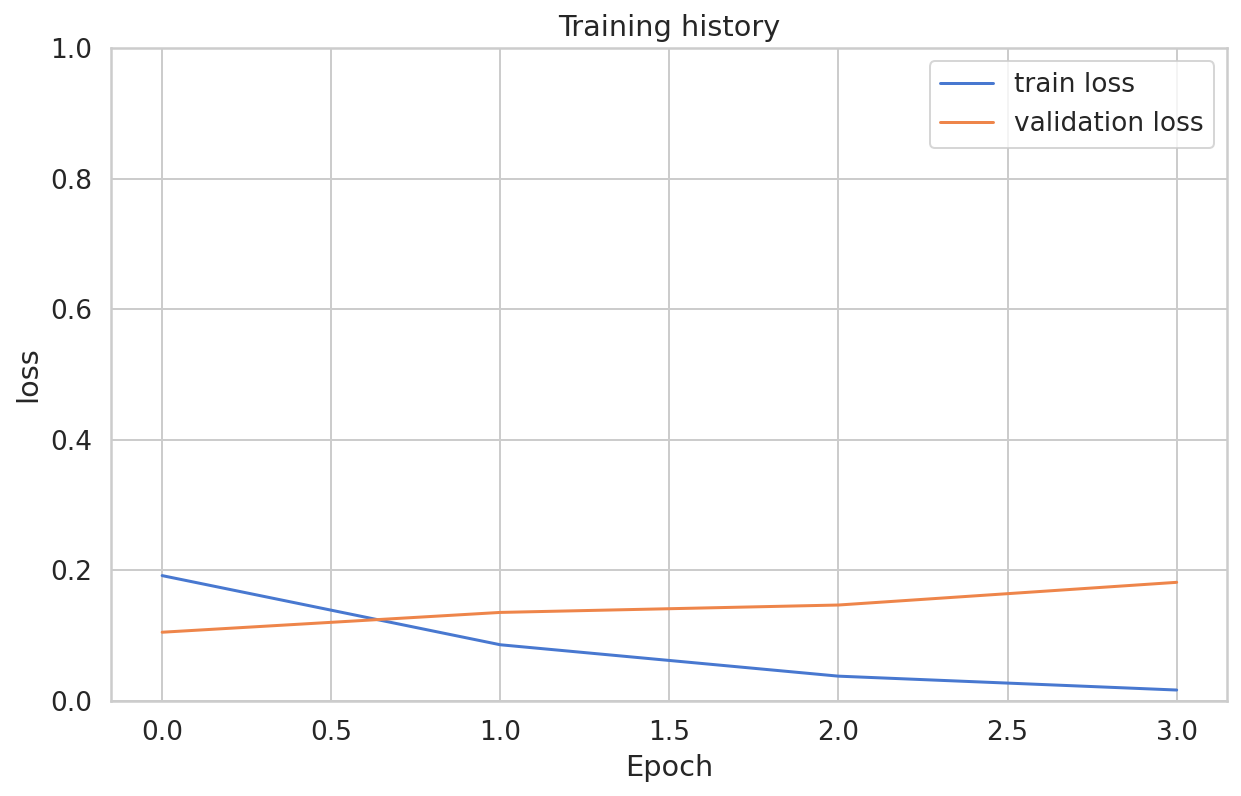

In [41]:
# We can look at the training vs validation losses

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

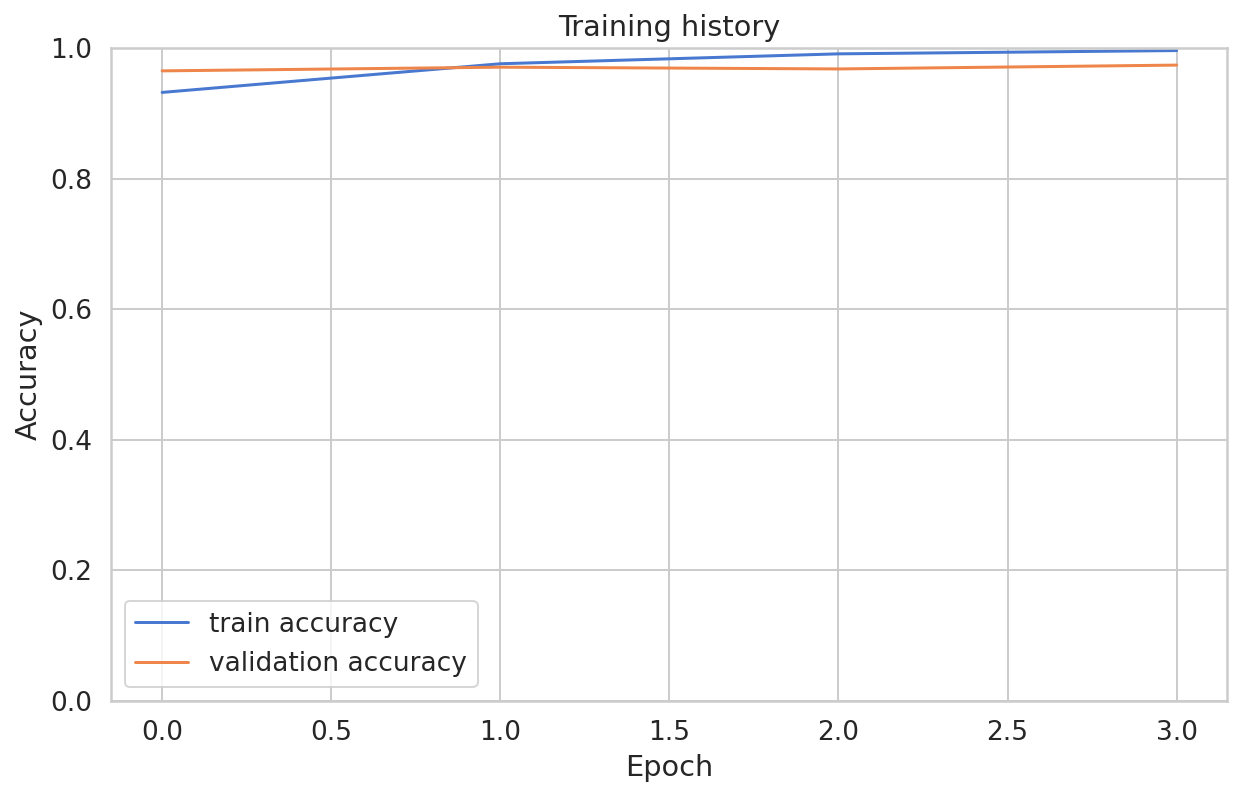

In [42]:
# We can look at the training vs validation accuracy:

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluating the model

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [43]:
%%time
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(test_df))

print('Accuracy = ' , test_acc.item() * 100, '%')
print('test_loss = ' , test_loss.item())

Accuracy =  96.0325283390833 %
test_loss =  0.27176969310444543
CPU times: user 13.3 s, sys: 5.37 s, total: 18.6 s
Wall time: 34.8 s


In [44]:
"""
The following is a helper function to get the predictions from our model using 
the test portion of the data.
"""

def get_predictions(model, data_loader):
    model = model.eval()
    
    news_text_strs = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["news_text_str"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            _, outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            news_text_strs.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return news_text_strs, predictions, prediction_probs, real_values

In [45]:
%%time
y_news_text_strs, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

CPU times: user 12.5 s, sys: 5.06 s, total: 17.6 s
Wall time: 33.8 s


In [46]:
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)) 

              precision    recall  f1-score   support

        FAKE     0.9596    0.9414    0.9504      1638
        REAL     0.9608    0.9731    0.9669      2420

    accuracy                         0.9603      4058
   macro avg     0.9602    0.9573    0.9587      4058
weighted avg     0.9603    0.9603    0.9603      4058



In [47]:
# Compute the Matthews correlation coefficient (MCC)

from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)
print('MCC = ', mcc * 100, '%') 

MCC =  91.74536897706875 %


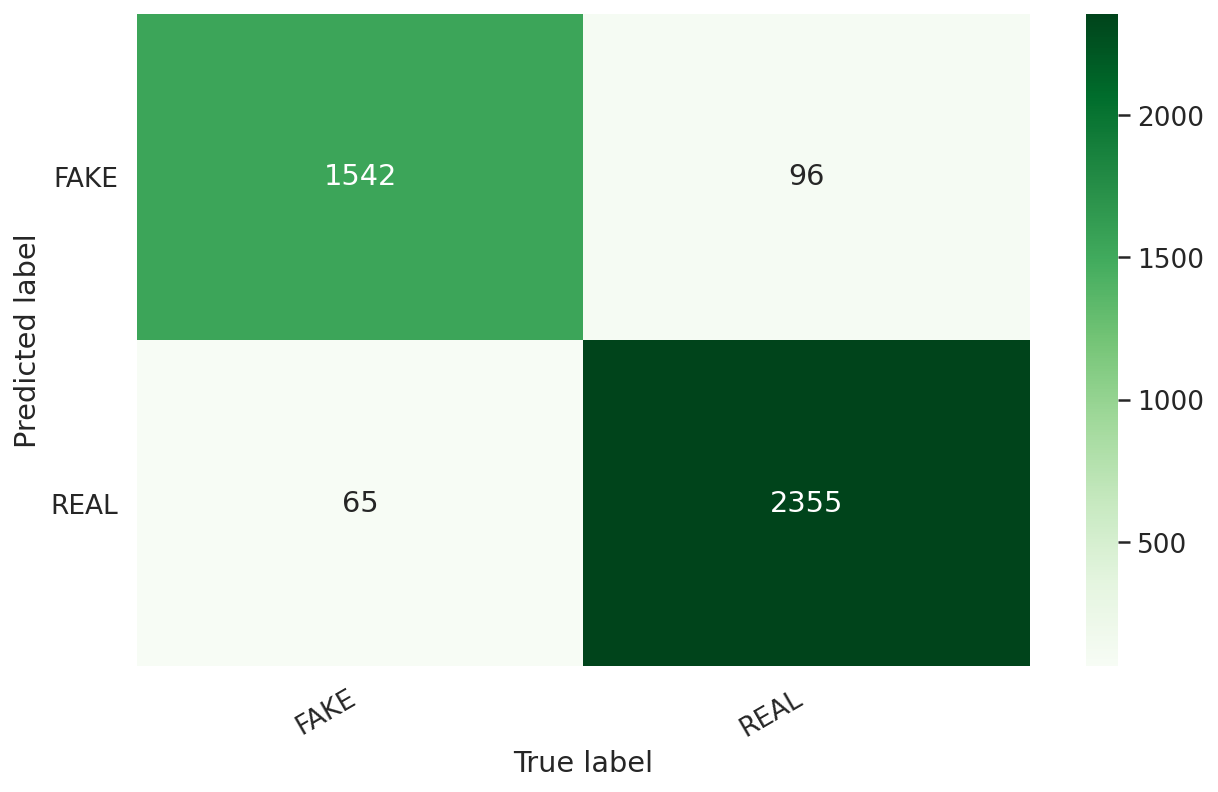

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.xlabel('True label')
    plt.ylabel('Predicted label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)

## Extracting the features from the pretrained model for LSTM

Next, we will extract the features (pooled_output) for each chunk as a vector/list of 768 item. Then we group the chunks from the same documents together in a single list and store the result back to a data frame. [source](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d)

In [49]:
"""
The following is a helper function to get the predictions from our model using 
the test portion of the data.
"""

def get_predictions2(model, data_loader):
    
    model = model.eval()
    
    featurs = []
    
    with torch.no_grad():
        for d in data_loader:

            texts = d["news_text_str"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            features, _ = model(input_ids=input_ids, attention_mask=attention_mask)
            
            featurs.extend(features)

    featurs = torch.stack(featurs).cpu()

    return featurs

In [50]:
%%time

tr_emb = get_predictions2(model, train_data_loader)

CPU times: user 2min 18s, sys: 53.8 s, total: 3min 12s
Wall time: 6min 14s


In [51]:
len(tr_emb)

45707

In [52]:
tr_emb2 = np.array(tr_emb)

In [53]:
tr_emb2.shape

(45707, 768)

In [54]:
df_train.shape

(21300, 5)

In [55]:
%%time
val_emb = get_predictions2(model, val_data_loader)
val_emb2 = np.array(val_emb)

CPU times: user 12.6 s, sys: 4.86 s, total: 17.4 s
Wall time: 34 s


In [56]:
val_emb2.shape, tr_emb2.shape

((4073, 768), (45707, 768))

In [57]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb2):
    if l in train_x.keys():
        train_x[l]  =np.vstack([train_x[l], emb])
    else:
        train_x[l] = [emb]

len(train_x.keys())

21300

In [58]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
    train_l_final.append(train_x[k])
    label_l_final.append(df_train.loc[k]['label'])

df_train2 = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train2.head()

,emb,label
0,"[[0.9514978, -0.6538513, -0.21186787, 0.449128...",1
1,"[[-0.9200754, 0.86085045, 0.18401766, -0.60036...",0
2,"[[0.95578766, -0.6672168, -0.25877315, 0.34283...",1
3,"[[0.961882, -0.70344204, -0.25340143, 0.503169...",1
4,"[[0.9619693, -0.6754576, -0.2592783, 0.4131367...",1


In [59]:
df_train.shape, df_train2.shape

((21300, 5), (21300, 2))

In [60]:
df_val.shape

(1879, 5)

In [61]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb2):
    if l in val_x.keys():
        val_x[l] = np.vstack([val_x[l], emb])
    else:
        val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
    val_l_final.append(val_x[k])
    vlabel_l_final.append(df_val.loc[k]['label'])

df_val2 = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val2.head()

,emb,label
0,"[[-0.89384913, 0.8322326, -0.6337785, 0.023502...",0
1,"[[-0.9101917, 0.86195, 0.07607714, -0.4764804,...",0
2,"[[0.9555731, -0.68706244, -0.3298565, 0.488874...",1
3,"[[0.95765007, -0.7186953, -0.51022136, 0.58486...",1
4,"[[0.95544696, -0.6499601, -0.5378356, 0.420369...",1


In [62]:
df_val2.shape

(1879, 2)

In [63]:
# import sys
# import numpy as np
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(threshold=sys.maxsize)

# df_train2.to_csv('train_features3.csv')
# df_val2.to_csv('val_features3.csv')

In [64]:
s = df_train2['emb'][0]

In [65]:
len(s),s

(3,
 array([[ 0.9514978 , -0.6538513 , -0.21186787, ..., -0.08126461,
          0.51559407, -0.65404487],
        [ 0.9319207 , -0.5265538 ,  0.8380826 , ...,  0.9384872 ,
          0.94314003,  0.29693833],
        [ 0.94586927, -0.6372421 , -0.06663259, ..., -0.01015935,
          0.50097626, -0.5474496 ]], dtype=float32))

In [66]:
v = []
for i in df_train2['emb']:
    v.append(len(i))
    
max(v), min(v)

(3, 1)

In [67]:
test_emb = get_predictions2(model, test_data_loader)
test_emb2 = np.array(test_emb)

aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb2):
    if l in test_x.keys():
        test_x[l] = np.vstack([test_x[l], emb])
    else:
        test_x[l] = [emb]


test_l_final = []
tlabel_l_final = []
for k in test_x.keys():
    test_l_final.append(test_x[k])
    tlabel_l_final.append(df_test.loc[k]['label'])

df_test2 = pd.DataFrame({'emb': test_l_final, 'label': tlabel_l_final})
df_test2.head()

,emb,label
0,"[[0.9648086, -0.71013045, -0.19503076, 0.51197...",1
1,"[[0.77177095, -0.36167786, 0.92867404, 0.73477...",1
2,"[[-0.92856085, 0.87233853, 0.17697775, -0.5332...",0
3,"[[-0.912634, 0.84681594, -0.35113016, -0.27693...",0
4,"[[0.9419792, -0.56377137, -0.19478491, 0.20573...",1


In [68]:
# df_test2.to_csv('test_features3.csv')

## LSTM

In [69]:
MASK_VALUE = -99.

The code commented out are an architectures we debated trying, but didn't get to. It consisted of using 3 concatenated lstm layers instead of 1.

In [70]:
# for i in range(3):
#   df_train2['lstm' + str(i)] = df_train2.emb.apply(lambda x: x[i] if i < len(x) else np.ones(768) * MASK_VALUE)

# for i in range(3):
#   df_val2['lstm' + str(i)] = df_val2.emb.apply(lambda x: x[i] if i < len(x) else np.ones(768) * MASK_VALUE)

# neuron_ratios = df_train2.emb.apply(len).value_counts()
# neuron_ratios /= neuron_ratios.sum()
# 500 * neuron_ratios

In [71]:
# from keras import layers, Model

# text_inputs = []
# to_concat = []
# for i in range(3):
#   text_input = layers.Input(shape=[None,768], dtype='float32', name='text'+str(i))
#   text_inputs.append(text_input)
#   #the mask layer
#   l_mask = layers.Masking(mask_value=MASK_VALUE, name='l_mask'+str(i))(text_input)
#   # Which we encoded in a single vector via a LSTM
#   encoded_text = layers.LSTM(100,name='lstm'+str(i))(l_mask)
#   out_dense = layers.Dense(30, activation='relu', name='dense'+str(i))(encoded_text)
#   to_concat.append(out_dense)

# concat = layers.Concatenate()(to_concat)
# # And we add a softmax classifier on top
# out = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(concat)
# # At model instantiation, we specify the input and the output:
# model = Model(text_inputs, out)
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['acc'])
# model.summary()

In [72]:
# X_train, X_val = [], []
# for i in range(3):
#   X_train.append(np.array(df_train2['lstm'+str(i)].to_list()))
#   X_val.append(np.array(df_val2['lstm'+str(i)].to_list()))
# print(np.array(X_val).shape)

# model.fit(
#     X_train,
#     np.array(df_train2.label.apply(lambda x: [x]).to_list()),
#     validation_data=(
#         X_val,
#         np.array(df_val2.label.apply(lambda x: [x]).to_list())),
#     batch_size=32, epochs=3
# )

In [80]:
from tensorflow.keras import layers, Model
text_input = layers.Input(shape=(None,768,), dtype='float32', name='text')

num_features= 768

l_mask = layers.Masking(mask_value=MASK_VALUE)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(200,)(l_mask)
out_dense = layers.Dense(60, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               775200    
_________________________________________________________________
dense_2 (Dense)              (None, 60)                12060     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 122       
Total params: 787,382
Trainable params: 787,382
Non-trainable params: 0
_________________________________________________________________


In [74]:
df_train2

,emb,label
0,"[[0.9514978, -0.6538513, -0.21186787, 0.449128...",1
1,"[[-0.9200754, 0.86085045, 0.18401766, -0.60036...",0
2,"[[0.95578766, -0.6672168, -0.25877315, 0.34283...",1
3,"[[0.961882, -0.70344204, -0.25340143, 0.503169...",1
4,"[[0.9619693, -0.6754576, -0.2592783, 0.4131367...",1
...,...,...
21295,"[[-0.90869915, 0.86188984, -0.015288965, -0.36...",0
21296,"[[0.95065576, -0.63510716, -0.070736334, 0.422...",1
21297,"[[0.96218294, -0.6973995, -0.38777485, 0.53113...",1
21298,"[[0.94651634, -0.6682651, -0.46734613, 0.53917...",1


In [78]:
num_sequences = len(df_train2['emb'].to_list())
print(num_sequences)
batch_size = 1
for i in range(int(np.sqrt(num_sequences_val)), -1, -1):
    if num_sequences % i == 0:
        batch_size = i
        break
batches_per_epoch = num_sequences // batch_size
print(batch_size)
assert batch_size * batches_per_epoch == num_sequences
def train_generator(df):
    x_list = df['emb'].to_list()
    y_list = df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            timesteps = len(max(x_list[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), MASK_VALUE)
            y_train = np.zeros((batch_size, 1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

21300
30


In [76]:
num_sequences_val = len(df_val2['emb'].to_list())
print(num_sequences_val)
batch_size_val = 1
for i in range(int(np.sqrt(num_sequences_val)), -1, -1):
    if num_sequences_val % i == 0:
        batch_size_val = i
        break
batches_per_epoch_val = num_sequences_val // batch_size_val
print(batch_size_val)
assert batch_size_val * batches_per_epoch_val == num_sequences_val
def val_generator(df):
    x_list = df['emb'].to_list()
    y_list = df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            timesteps = len(max(x_list[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), MASK_VALUE)
            y_train = np.zeros((batch_size_val, 1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

1879
1


In [81]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)
model_checkpoint = ModelCheckpoint(
                      filepath='klfhuhwuifgheiru',
                      monitor='val_acc',
                      save_weights_only=True,
                      save_best_only=True)

model.fit(train_generator(df_train2), steps_per_epoch=batches_per_epoch, epochs=30,
          validation_data=val_generator(df_val2), validation_steps=batches_per_epoch_val,
          callbacks =[call_reduce, model_checkpoint])

model.load_weights('klfhuhwuifgheiru')

Epoch 1/30
710/710 [==============================] - 10s 15ms/step - loss: 0.0059 - acc: 0.4492 - val_loss: 0.0455 - val_acc: 0.5008
Epoch 2/30
710/710 [==============================] - 9s 13ms/step - loss: 0.0021 - acc: 0.4083 - val_loss: 0.0313 - val_acc: 0.4753
Epoch 3/30
710/710 [==============================] - 9s 13ms/step - loss: 0.0015 - acc: 0.4777 - val_loss: 0.0347 - val_acc: 0.4391
Epoch 4/30
710/710 [==============================] - 10s 14ms/step - loss: 0.0014 - acc: 0.4738 - val_loss: 0.0324 - val_acc: 0.5668
Epoch 5/30
710/710 [==============================] - 10s 14ms/step - loss: 0.0014 - acc: 0.6597 - val_loss: 0.0362 - val_acc: 0.6307
Epoch 6/30
710/710 [==============================] - 10s 13ms/step - loss: 0.0014 - acc: 0.7803 - val_loss: 0.0355 - val_acc: 0.6663
Epoch 7/30
710/710 [==============================] - 9s 13ms/step - loss: 0.0014 - acc: 0.3565 - val_loss: 0.0353 - val_acc: 0.5519
Epoch 8/30
710/710 [==============================] - 9s 13ms/ste

In [82]:
model.evaluate(val_generator(df_test2), steps=batches_per_epoch_val)

1879/1879 [==============================] - 2s 1ms/step - loss: 0.0837 - acc: 0.6658


[0.08373638987541199, 0.6657796502113342]

Very strange performance! This is an interesting model, but obviously our implementation on this data is no competition for Longformer or even vanilla LSTM (yet!). This might reflect how little data we had to train on.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [Hierarchical Transformers for Long Document Classification](https://arxiv.org/abs/1910.10781)
- [Using BERT For Classifying Documents with Long Texts](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)